In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Livestock posterior (kt / period) × cattle statistics
— кореляція, таблиці, карти, scatter
"""

# ──────────── стандартні пакети ───────────────────────────────────────────
from pathlib import Path
import numpy as np, pandas as pd, xarray as xr, yaml, warnings
import geopandas as gpd, regionmask
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import pearsonr

# ──────────── 0. константи / шляхи ────────────────────────────────────────
BASE     = Path("/home/hermit/imi_output_dir")   # каталоги IMI-періодів
EXCEL    = Path("Livestock_zb.xlsx")             # збірник ДССУ
SHAPE    = Path("regions.shp")                   # 27 областей
OUT_TAB  = Path("tables");         OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_MAP  = Path("maps_livestock"); OUT_MAP.mkdir(parents=True, exist_ok=True)

PERIODS = [
    "PreWar_SepOct2021",
    "WarOnset_FebMar2022",
    "WarOnset_MayJun2022",
    "War_FebMar2023",
    "War_JunJul2023",
]
PERIOD2YR = {
    "PreWar_SepOct2021": 2021,
    "WarOnset_FebMar2022": 2022,
    "WarOnset_MayJun2022": 2022,
    "War_FebMar2023": 2023,
    "War_JunJul2023": 2023,
}

# точна тривалість кожного періоду (днів)
DAYS_PER = {
    "PreWar_SepOct2021": 61,
    "WarOnset_FebMar2022": 59,   
    "WarOnset_MayJun2022": 61,
    "War_FebMar2023": 59,        
    "War_JunJul2023": 61,
}

SEC_PER_DAY = 86_400
KG2KT       = 1e-6              # kg → kt

# ──────────── 1. області + mask ───────────────────────────────────────────
gdf_obl  = gpd.read_file(SHAPE).to_crs(4326)
mask_obl = regionmask.Regions(gdf_obl.geometry.values,
                              names=gdf_obl["TITLE"].tolist(),
                              name="obl")

# ──────────── 2. Excel → heads_df (thsd heads) ────────────────────────────
def load_heads(xls: Path = EXCEL) -> pd.DataFrame:
    """Повертає DataFrame (index = Oblast, columns = Year)."""
    wide = (pd.read_excel(xls)
              .rename(columns={"period": "Year",
                               "Donetska":  "Donetska_1",
                               "Luhanska":  "Luhanska_1"}))

    long = (wide.melt(id_vars="Year", var_name="Oblast",
                      value_name="Heads")
                  .dropna(subset=["Heads"]))
    long["Heads"] = pd.to_numeric(long["Heads"], errors="coerce")

    return (long.pivot_table(index="Oblast", columns="Year",
                             values="Heads", aggfunc="first")
                 .reindex(gdf_obl["TITLE"]))

# ──────────── 3. emis kt / period ─────────────────────────────────────────
def emis_series(period: str, sector: str = "Livestock") -> pd.Series:
    days = DAYS_PER[period]

    run  = BASE / period
    with open(run / f"config_{run.name}.yml") as f:
        nbuf = int(yaml.safe_load(f).get("nBufferClusters", 0))

    ds   = xr.open_dataset(run / "inversion/output/netCDF/posterior.nc")
    da   = ds[f"EmisCH4_{sector}"]
    if "time" in da.dims:
        da = da.mean("time")
    area = ds["AREA"]

    sv   = xr.open_dataset(run / "StateVector.nc")["StateVector"]
    roi  = sv <= (int(np.nanmax(sv)) - nbuf)

    kg = da * area * roi * SEC_PER_DAY * days       # kg за увесь період
    kt = kg * KG2KT                                 # → kt

    sums = kt.groupby(mask_obl.mask(kt)).sum()
    return pd.Series({name: sums.sel(mask=i).item()
                      if i in sums["mask"] else np.nan
                      for i, name in enumerate(mask_obl.names)},
                     name=period)

def emis_df() -> pd.DataFrame:
    """rows = periods, cols = Oblast."""
    return pd.DataFrame({p: emis_series(p) for p in PERIODS}).T

# ──────────── 4. кореляція + візуалізація ─────────────────────────────────
def corr_and_maps():
    heads = load_heads()      # Oblast × Year
    emis  = emis_df()         # Period × Oblast
    emis.to_csv(OUT_TAB / "Livestock_emissions_kt_period.csv")

    miss_kw = dict(color="lightgrey", edgecolor="k",
                   hatch="///", label="No data")

    for per in PERIODS:
        yr  = PERIOD2YR[per]
        e,h = emis.loc[per], heads[yr]

        common = e.index.intersection(h.index)
        e,h    = e.loc[common], h.loc[common]
        mask   = ~(e.isna() | h.isna())

        r,p = (pearsonr(e[mask], h[mask])
               if mask.sum() >= 3 else (np.nan, np.nan))

        pd.DataFrame({"Emis_kt": e, "Heads_thsd": h})\
          .to_csv(OUT_TAB / f"Livestock_{per}.csv")

        gdf = gdf_obl.set_index("TITLE").copy()
        gdf["Emis"], gdf["Heads"] = e, h

        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        gdf.plot("Emis", cmap="turbo", legend=True,
                 edgecolor="k", linewidth=.4, missing_kwds=miss_kw, ax=ax[0])
        ax[0].set_title(f"CH₄, kt / {DAYS_PER[per]} d\n{per}")
        ax[0].axis("off")

        gdf.plot("Heads", cmap="YlGn", legend=True,
                 edgecolor="k", linewidth=.4, missing_kwds=miss_kw, ax=ax[1])
        ax[1].set_title(f"Cattle, тис. голів\n{yr}")
        ax[1].axis("off")

        sns.regplot(x=h[mask], y=e[mask], ax=ax[2],
                    scatter_kws=dict(s=55), line_kws=dict(color="red"))
        ax[2].set_xlabel("Cattle, thsd heads")
        ax[2].set_ylabel(f"CH₄, kt / {DAYS_PER[per]} d")
        ax[2].yaxis.set_major_formatter(FuncFormatter(lambda x,_:f"{x:,.1f}"))
        ax[2].grid(True, ls="--", alpha=.35)
        ax[2].set_title(f"r = {r:.2f};   p = {p:.3g}")

        fig.suptitle("Livestock posterior vs cattle stats", y=.98, size=14)
        fig.tight_layout()
        fn = OUT_MAP / f"Livestock_{per}.png"
        fig.savefig(fn, dpi=200)
        plt.show()

        print(f"{per:<22}  r={r:.3f}  p={p:.3g}  n={mask.sum()}   → {fn}")

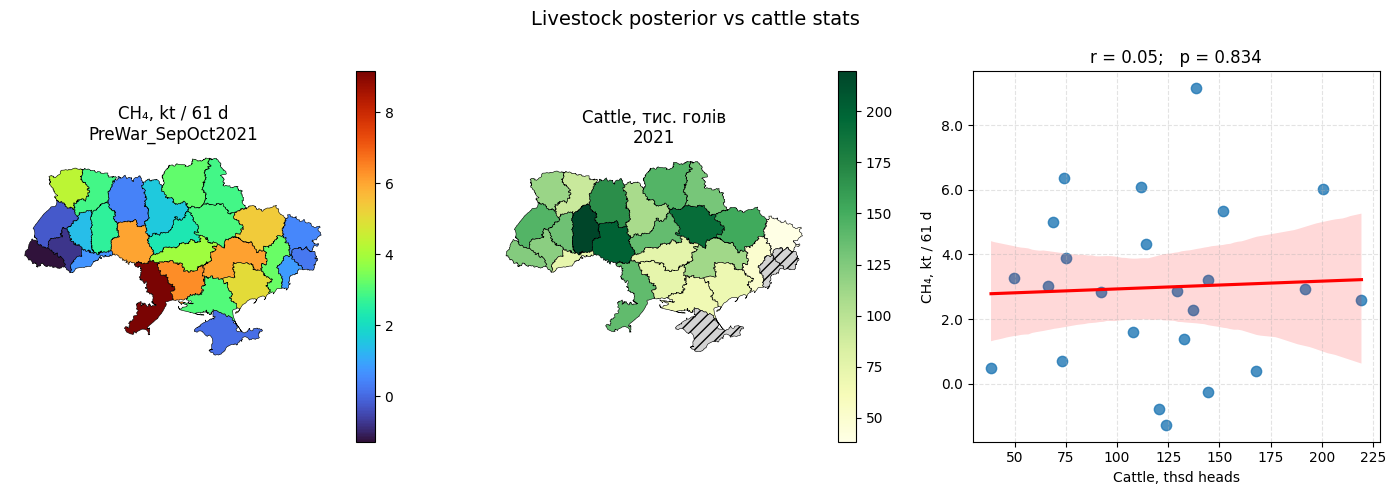

PreWar_SepOct2021       r=0.045  p=0.834  n=24   → maps_livestock/Livestock_PreWar_SepOct2021.png


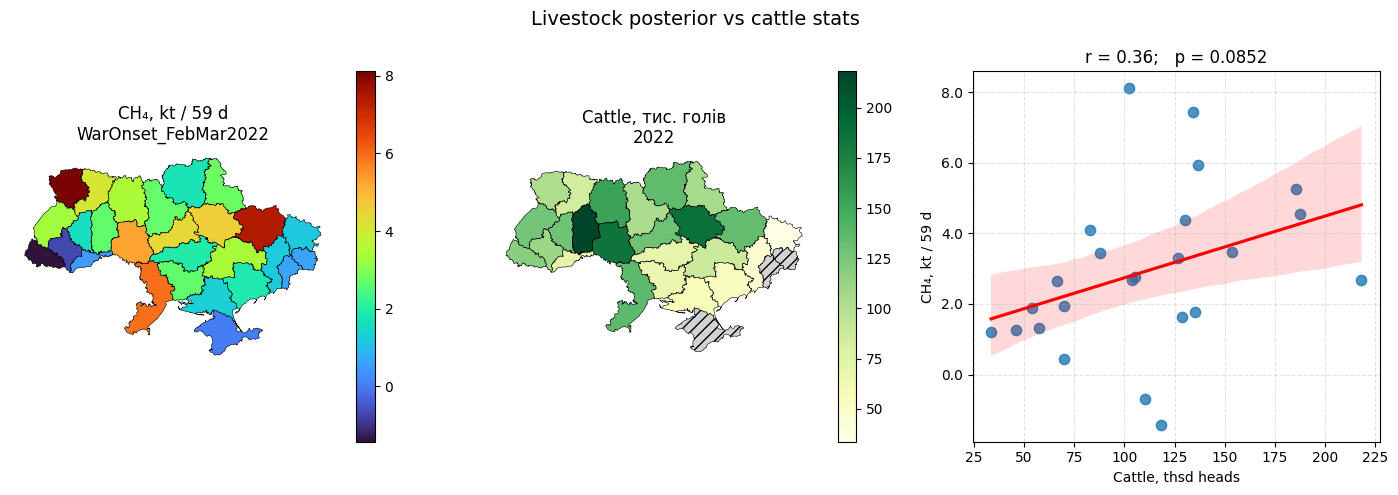

WarOnset_FebMar2022     r=0.359  p=0.0852  n=24   → maps_livestock/Livestock_WarOnset_FebMar2022.png


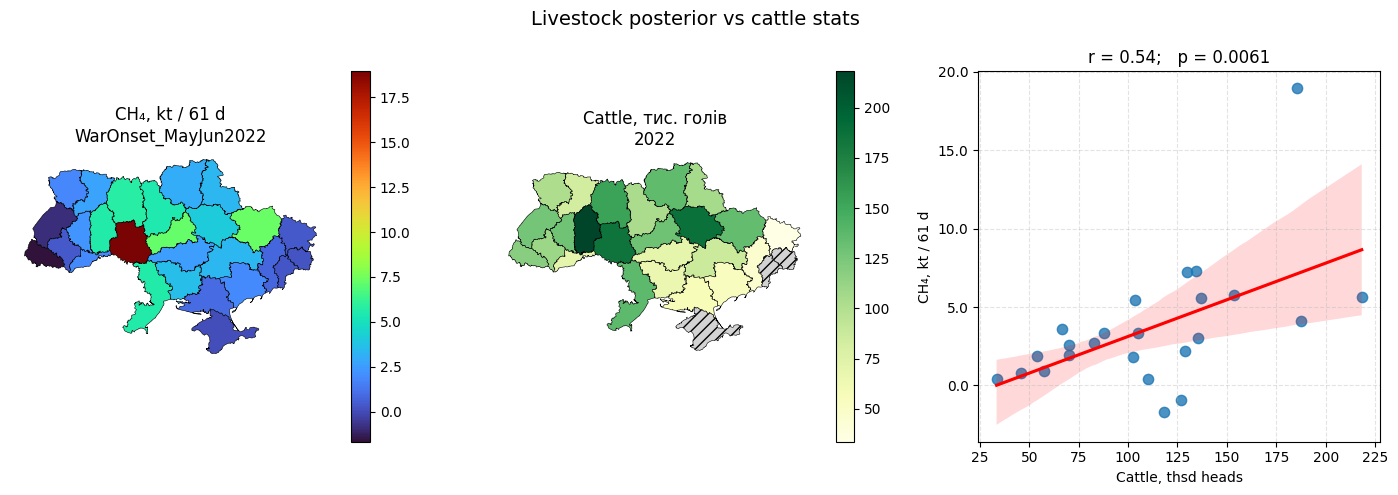

WarOnset_MayJun2022     r=0.543  p=0.0061  n=24   → maps_livestock/Livestock_WarOnset_MayJun2022.png


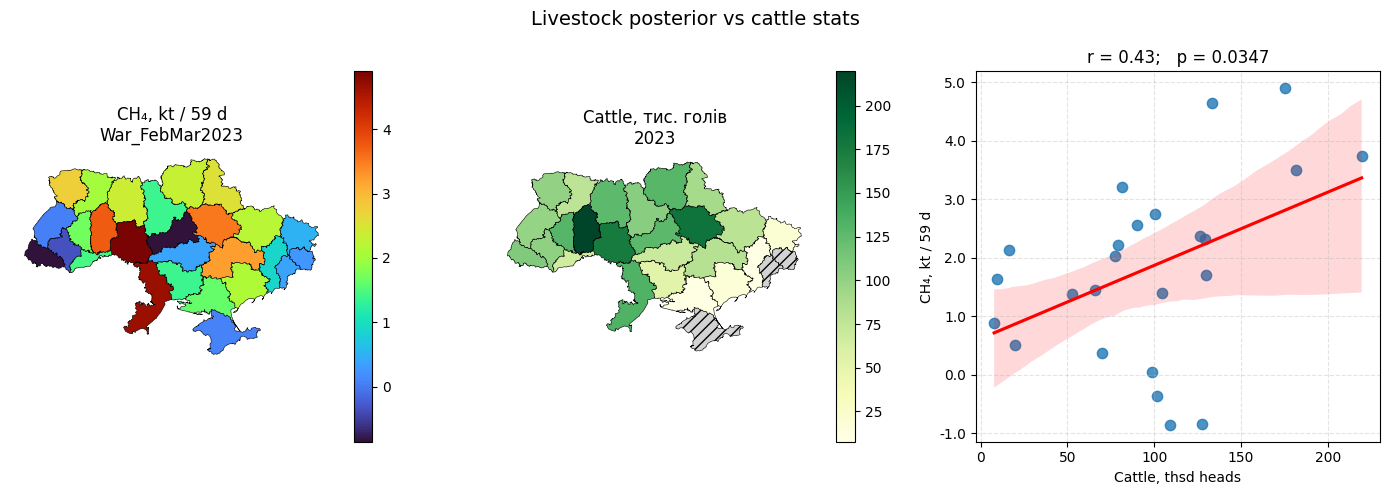

War_FebMar2023          r=0.433  p=0.0347  n=24   → maps_livestock/Livestock_War_FebMar2023.png


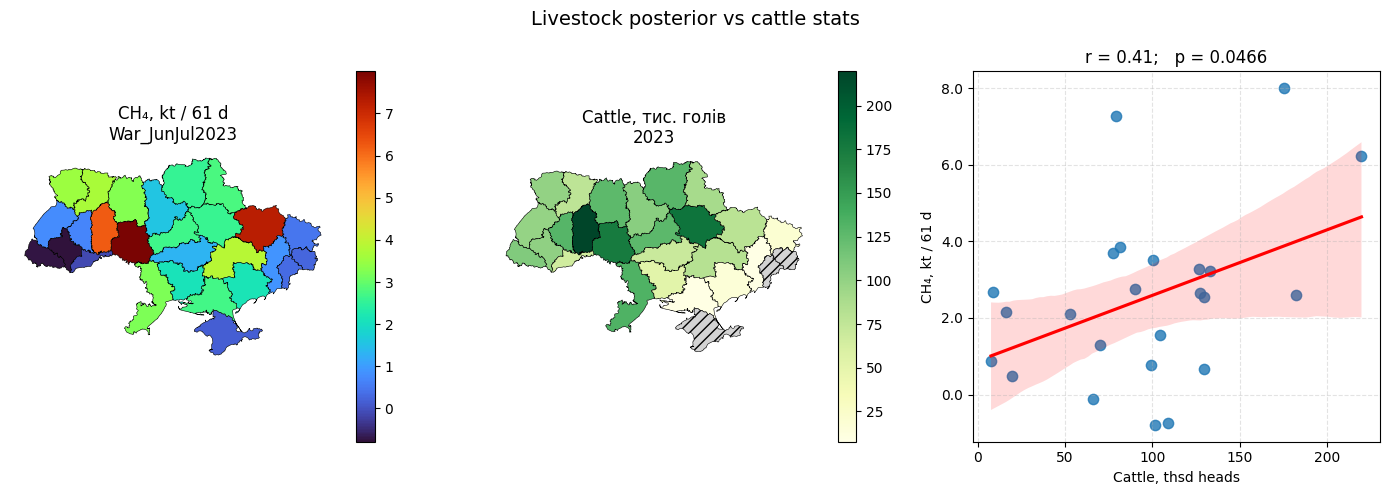

War_JunJul2023          r=0.410  p=0.0466  n=24   → maps_livestock/Livestock_War_JunJul2023.png


In [2]:
# ──────────── 5. RUN ──────────────────────────────────────────────────────
if __name__ == "__main__":
    corr_and_maps()